Epoch 1/50


<ipython-input-7-74bd3d50053f>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 4.8895e-04 - val_loss: 7.5077e-04
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.2470e-04 - val_loss: 6.8489e-04
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.6806e-04 - val_loss: 8.3714e-04
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.6264e-04 - val_loss: 5.2677e-04
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.2850e-04 - val_loss: 5.5333e-04
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2.3242e-04 - val_loss: 8.5620e-04
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.3027e-04 - val_loss: 5.6939e-04
Epoch 9/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.3658e-04 - val_loss: 5.6833e-04
Epoch 10/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 2.0650e-04 - val_loss: 0.0012
Epoch 11/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2.0501e-04

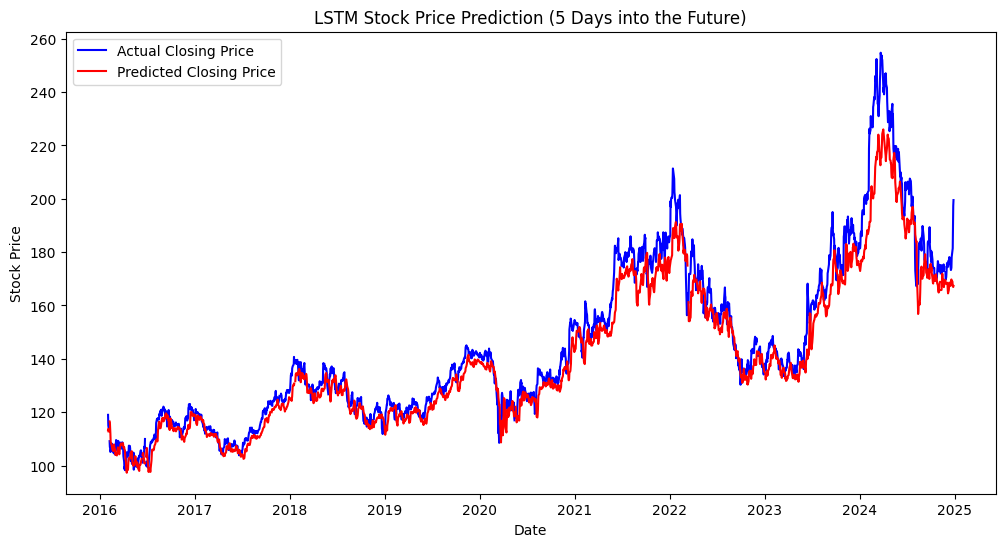

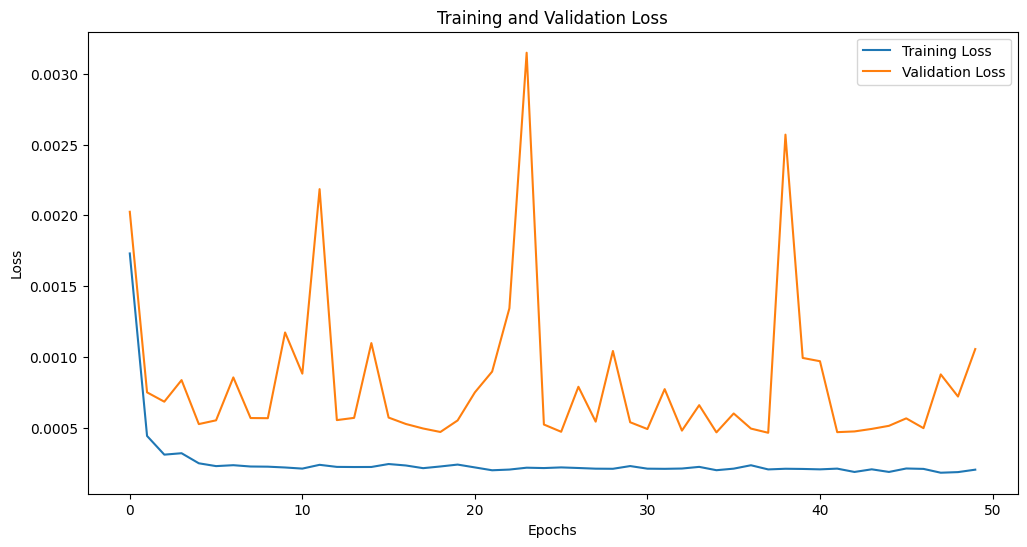

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Load the dataset
df = pd.read_csv('question4-stock-data.csv')

# Convert 'Date' column to datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Handle missing values by forward filling
df.fillna(method='ffill', inplace=True)

# Feature Engineering
# Add Moving Averages
df['MA_10'] = df['Close'].rolling(window=10).mean()  # 10-day moving average
df['MA_50'] = df['Close'].rolling(window=50).mean()  # 50-day moving average

# Add Volatility (rolling standard deviation)
df['Volatility'] = df['Close'].rolling(window=10).std()

# Add Momentum (difference between current and past closing price)
df['Momentum'] = df['Close'] - df['Close'].shift(4)

# Add Lag Features
df['Close_lag1'] = df['Close'].shift(1)  # 1-day lag
df['Close_lag2'] = df['Close'].shift(2)  # 2-day lag

# Drop rows with NaN values (created by rolling windows and lag features)
df.dropna(inplace=True)

# Feature selection
features = ['Close', 'MA_10', 'MA_50', 'Volatility', 'Momentum', 'Close_lag1', 'Close_lag2']
data = df[features].values

# Normalize the data using MinMaxScaler (scale between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_sequences(data, time_steps=30, future_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps - future_steps + 1):
        X.append(data[i:(i + time_steps), :])  # Use all features
        y.append(data[i + time_steps + future_steps - 1, 0])  # Predict 'Close' price 5 days into the future
    return np.array(X), np.array(y)

# Define time steps and future steps
time_steps = 30  # Use 30 days of historical data
future_steps = 5  # Predict 5 days into the future

# Create sequences
X, y = create_sequences(data_scaled, time_steps, future_steps)

# Train-test split (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(time_steps, len(features))),  # Bidirectional LSTM layer
    Dropout(0.3),  # Dropout to prevent overfitting
    Bidirectional(LSTM(100, return_sequences=False)),  # Second Bidirectional LSTM layer
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(50),  # Fully connected layer
    Dense(1)  # Output layer (predicts the closing price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values to get actual stock prices
dummy_array_pred = np.zeros((len(y_pred), len(features)))
dummy_array_pred[:, 0] = y_pred.flatten()
y_pred_inv = scaler.inverse_transform(dummy_array_pred)[:, 0]

dummy_array_test = np.zeros((len(y_test), len(features)))
dummy_array_test[:, 0] = y_test.flatten()
y_test_inv = scaler.inverse_transform(dummy_array_test)[:, 0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'RMSE: {rmse}')

# Plot actual vs predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual Closing Price', color='blue')
plt.plot(df.index[-len(y_test):], y_pred_inv, label='Predicted Closing Price', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('LSTM Stock Price Prediction (5 Days into the Future)')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-8-8afbaf2cb1c4>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_day_features[0, 0] = next_day_pred  # Predicted closing price
<ipython-input-8-8afbaf2cb1c4>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_day_features[0, 4] = next_day_pred - last_sequence[-1, 0]  # Momentum


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predictions saved to 'next_5_days_predictions.csv'
Predicted Closing Prices for the Next 5 Days:
        Date  Predicted_Close
0 2024-12-28       183.203593
1 2024-12-29       167.739669
2 2024-12-30       159.564841
3 2024-12-31       154.748721
4 2025-01-01       151.114172


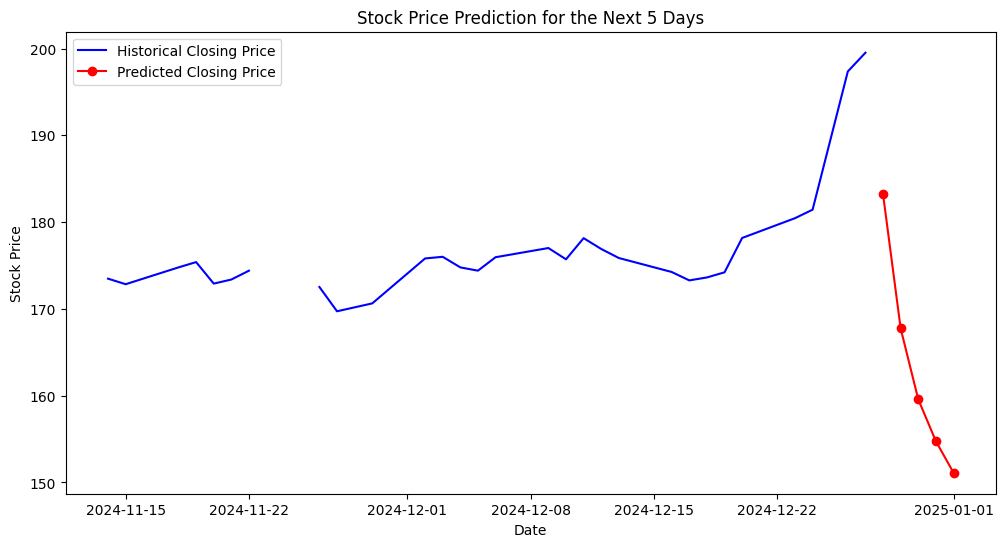

In [8]:
# Use the last `time_steps` days of data to predict the next 5 days
last_sequence = data_scaled[-time_steps:]  # Last 30 days of data
next_5_days_predictions = []

# Predict the next 5 days iteratively
for _ in range(5):
    # Reshape the last sequence to match the model's input shape
    last_sequence_reshaped = last_sequence.reshape(1, time_steps, len(features))

    # Predict the next day's closing price
    next_day_pred = model.predict(last_sequence_reshaped)

    # Append the prediction to the results
    next_5_days_predictions.append(next_day_pred.flatten()[0])

    # Create a new row for the next day's features
    next_day_features = np.zeros((1, len(features)))

    # Update the features for the next day
    next_day_features[0, 0] = next_day_pred  # Predicted closing price
    next_day_features[0, 1] = last_sequence[-1, 1]  # Carry forward MA_10
    next_day_features[0, 2] = last_sequence[-1, 2]  # Carry forward MA_50
    next_day_features[0, 3] = last_sequence[-1, 3]  # Carry forward Volatility
    next_day_features[0, 4] = next_day_pred - last_sequence[-1, 0]  # Momentum
    next_day_features[0, 5] = last_sequence[-1, 0]  # Close_lag1 (previous day's closing price)
    next_day_features[0, 6] = last_sequence[-1, 5]  # Close_lag2 (two days ago's closing price)

    # Update the last sequence by removing the first day and adding the predicted day
    last_sequence = np.vstack([last_sequence[1:], next_day_features])

# Inverse transform the predictions to get actual stock prices
next_5_days_predictions = np.array(next_5_days_predictions).reshape(-1, 1)
dummy_array = np.zeros((len(next_5_days_predictions), len(features)))
dummy_array[:, 0] = next_5_days_predictions.flatten()
next_5_days_predictions_inv = scaler.inverse_transform(dummy_array)[:, 0]

# Create dates for the next 5 days
last_date = df.index[-1]
next_5_days_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5)

# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame({
    'Date': next_5_days_dates,
    'Predicted_Close': next_5_days_predictions_inv
})

# Save the predictions to a CSV file
predictions_df.to_csv('next_5_days_predictions.csv', index=False)
print("Predictions saved to 'next_5_days_predictions.csv'")

# Print the predictions
print("Predicted Closing Prices for the Next 5 Days:")
print(predictions_df)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[-30:], df['Close'][-30:], label='Historical Closing Price', color='blue')
plt.plot(next_5_days_dates, next_5_days_predictions_inv, label='Predicted Closing Price', color='red', marker='o')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for the Next 5 Days')
plt.legend()
plt.show()